In [46]:
using DataFrames
using Random
using Turing
using Distributions
using StatsPlots
using MCMCChains
using StatsFuns
using ReverseDiff
using Memoization
using SpecialFunctions

In [199]:
seed = 123456
Random.seed!(seed)

gpd = 10
n_days = 1000

tvec = []
true_log_λ = []
true_Δ_μ = 0.0
true_Δ_σ = 0.01
scores = []

t = 1
rand_log_λ = rand(Normal(2,0.05))
push!(true_log_λ, rand_log_λ)
for i = 1:gpd
    push!(tvec, t)
    rand_score = rand(Poisson(exp(rand_log_λ)))
    push!(scores, rand_score)
end

for t = 2:n_days
    rand_log_λ += rand(Normal(true_Δ_μ, true_Δ_σ)) + 0.001
    push!(true_log_λ, rand_log_λ)
    for i = 1:gpd
        push!(tvec, t)
        rand_score = rand(Poisson(exp(rand_log_λ)))
        push!(scores, rand_score)
    end
end

In [200]:
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)

true

In [201]:
# https://github.com/StatisticalRethinkingJulia/MCMCBenchmarks.jl/pull/39
struct LogPoisson{T<:Real} <: Distributions.DiscreteUnivariateDistribution
    logλ::T
end

function Distributions.logpdf(lp::LogPoisson, k::Int)
    return k * lp.logλ - exp(lp.logλ) - (logabsgamma(k + 1))[1]
end

Broadcast.broadcastable(d::LogPoisson{Float64}) = Ref(d)

In [202]:
@model rw_poisson(s, p) = begin
    log_λ ~ Normal(p[:log_λ][1], p[:log_λ][2])
    Δλ ~ Normal(p[:Δλ][1], p[:Δλ][2])
    log_λ = log_λ + Δλ
    s .~ LogPoisson.(log_λ)
end
;

In [1]:
function get_posteriors(chain)
    chdf = DataFrame(chain)
    p = Dict()
    Δλ_mle = fit_mle(Normal, chdf[:, "Δλ"])
    p[:Δλ] = (Δλ_mle.μ, Δλ_mle.σ)
    log_λ_mle = fit_mle(Normal, chdf[:,"log_λ"] .+ chdf[:, "Δλ"])
    p[:log_λ] = (log_λ_mle.μ, log_λ_mle.σ)
    return p
end

get_posteriors (generic function with 1 method)

In [2]:
start_day = 1
ws = 1
s = 1
end_day = n_days

#n_days = end_day - start_day

inferred_variables = DataFrame(
    day = [],
    log_λ = [],
    Δλ = []
)

p = Dict(
    :Δλ => (0.001, 0.001),
    :log_λ => (1.5, 0.5),
)

for t = 1:s:(end_day - start_day + 1)
    s = scores[(tvec .== t)]
    @model rw_poisson(s, p) = begin
        log_λ ~ Normal(p[:log_λ][1], p[:log_λ][2])
        Δλ ~ Normal(p[:Δλ][1], p[:Δλ][2])
        log_λ = log_λ + Δλ
        s .~ LogPoisson.(log_λ)
    end
    m = rw_poisson(s, p)
    chain = sample(m, NUTS(1000, 0.65), 1000)
    p = posteriors = get_posteriors(chain)

    inferred = []
    push!(inferred, t)
    push!(inferred, Normal(posteriors[:log_λ][1], posteriors[:log_λ][2])) # λ
    push!(inferred, Normal(posteriors[:Δλ][1], posteriors[:Δλ][2]))       # Δλ
    push!(inferred_variables, inferred)
end

UndefVarError: UndefVarError: n_days not defined

In [3]:
function nhl_inference_plot(lvars, ivars, vname)
    ldays = lvars[:,:day]
    ly = lvars[:,vname]
    idays = ivars[:,:day]
    iy = ivars[:,vname]
    iyμ = [y.μ for y in iy]
    iyσ = [y.σ for y in iy]
    plot(ldays, ly)
    plot!(idays, iyμ, ribbon=iyσ)
end

nhl_inference_plot (generic function with 1 method)

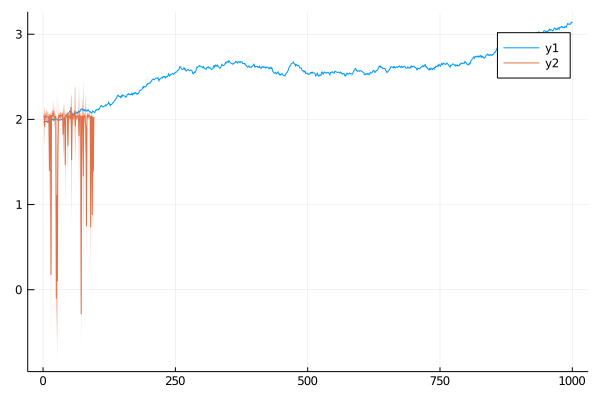

In [206]:
latent_variables = DataFrame(day = 1:n_days, log_λ = true_log_λ)
nhl_inference_plot(latent_variables[1:n_days, :], inferred_variables, :log_λ)